In [ ]:
# -------------------------------------------------
# 1. Mount Google Drive
# -------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------------------------
# 2. Set paths
# -------------------------------------------------
BASE = '/content/drive/MyDrive'  # Your root

TRAIN_DIR = f'{BASE}/train'
VALID_DIR = f'{BASE}/validate'
TEST_DIR  = f'{BASE}/test'

# -------------------------------------------------
# 3. Verify folders
# -------------------------------------------------
import os
for p in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
    print(f"{p} → exists? {os.path.isdir(p)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/train → exists? True
/content/drive/MyDrive/validate → exists? True
/content/drive/MyDrive/test → exists? True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm
import os

In [ ]:
class DeepfakeDatasetLoader:
    def __init__(self, train_dir, val_dir, test_dir, batch_size=32, img_sz=224):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.bs = batch_size
        self.sz = img_sz

        self.train_tf = T.Compose([
            T.RandomResizedCrop(img_sz, scale=(0.8, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(15),
            T.ColorJitter(0.2, 0.2, 0.2),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.val_tf = T.Compose([
            T.Resize((img_sz, img_sz)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def get_loaders(self):
        train_ds = datasets.ImageFolder(self.train_dir, self.train_tf)
        val_ds   = datasets.ImageFolder(self.val_dir,   self.val_tf)
        test_ds  = datasets.ImageFolder(self.test_dir,  self.val_tf)

        train_loader = DataLoader(train_ds, batch_size=self.bs, shuffle=True,  num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.bs, shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.bs, shuffle=False, num_workers=2, pin_memory=True)

        return train_loader, val_loader, test_loader, train_ds.classes

# Create loaders
loader = DeepfakeDatasetLoader(TRAIN_DIR, VALID_DIR, TEST_DIR, batch_size=32, img_sz=224)
train_loader, val_loader, test_loader, class_names = loader.get_loaders()

print(f"Classes: {class_names}  →  0 = Real, 1 = Fake")
print(f"Batches → Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Classes: ['0', '1']  →  0 = Real, 1 = Fake
Batches → Train: 219, Val: 47, Test: 47


In [ ]:
# -------------------------------------------------
# 4. Model – ResNet-18
# -------------------------------------------------
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # ---- Use weights instead of pretrained ----
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = resnet.fc.in_features
        resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1)
        )
        self.model = resnet

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# -------------------------------------------------
# Device
# -------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# -------------------------------------------------
# Model, loss, optimiser, scheduler
# -------------------------------------------------
model = DeepfakeDetector().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ---- No `verbose` argument ----
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

Using device: cuda


In [ ]:
def run_epoch(loader, model, criterion, opt=None, train=True):
    model.train() if train else model.eval()
    loss_sum = 0.0
    preds, trues = [], []

    for x, y in tqdm(loader, desc='Train' if train else 'Val', leave=False):
        x, y = x.to(device), y.to(device).float().unsqueeze(1)
        if train: opt.zero_grad()
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                loss.backward()
                opt.step()
        loss_sum += loss.item()
        pred = (out > 0.5).float()
        preds.extend(pred.cpu().numpy().flatten())
        trues.extend(y.cpu().numpy().flatten())

    return loss_sum / len(loader), accuracy_score(trues, preds)

# Training
EPOCHS = 30
PATIENCE = 5
best_val = float('inf')
wait = 0
history = {'t_loss':[], 't_acc':[], 'v_loss':[], 'v_acc':[]}

for epoch in range(1, EPOCHS + 1):
    t_loss, t_acc = run_epoch(train_loader, model, criterion, optimizer, train=True)
    v_loss, v_acc = run_epoch(val_loader,   model, criterion, train=False)

    scheduler.step(v_loss)
    history['t_loss'].append(t_loss); history['t_acc'].append(t_acc)
    history['v_loss'].append(v_loss); history['v_acc'].append(v_acc)

    print(f"Epoch {epoch:02d} | Train: {t_loss:.4f}/{t_acc:.4f} | Val: {v_loss:.4f}/{v_acc:.4f}")

    if v_loss < best_val:
        best_val = v_loss
        wait = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/deepfake_best.pth')
        print("  → Best model saved!")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping!")
            break

Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 01 | Train: 0.4416/0.7969 | Val: 0.5810/0.7207
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 02 | Train: 0.2572/0.8927 | Val: 0.2756/0.8827
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 03 | Train: 0.1866/0.9260 | Val: 0.1526/0.9467
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 04 | Train: 0.1474/0.9414 | Val: 0.2016/0.9200


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 05 | Train: 0.1180/0.9531 | Val: 0.2678/0.9000


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 06 | Train: 0.1110/0.9591 | Val: 0.1864/0.9327


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():  
^ ^^^ ^ ^ ^^ ^ ^ ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^ ^ ^ ^^ 
   File "/usr/lib/

Epoch 07 | Train: 0.0596/0.9791 | Val: 0.1123/0.9580
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 08 | Train: 0.0483/0.9841 | Val: 0.0980/0.9653
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 09 | Train: 0.0497/0.9830 | Val: 0.1083/0.9607


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10 | Train: 0.0404/0.9853 | Val: 0.1127/0.9627


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11 | Train: 0.0438/0.9844 | Val: 0.0897/0.9700
  → Best model saved!


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12 | Train: 0.0379/0.9867 | Val: 0.0921/0.9653


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20><function _MultiProcessingDataLoaderIter.__del__ at 0x7c99187e8c20>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
 if w.is_alive(): 
        ^ ^ ^^^ ^^ ^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^ ^
  File "/usr/lib/pyth

Epoch 13 | Train: 0.0303/0.9884 | Val: 0.1061/0.9640


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14 | Train: 0.0307/0.9883 | Val: 0.1025/0.9667


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15 | Train: 0.0250/0.9907 | Val: 0.1007/0.9687


Train:   0%|          | 0/219 [00:00<?, ?it/s]

Val:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16 | Train: 0.0197/0.9939 | Val: 0.0982/0.9667
Early stopping!


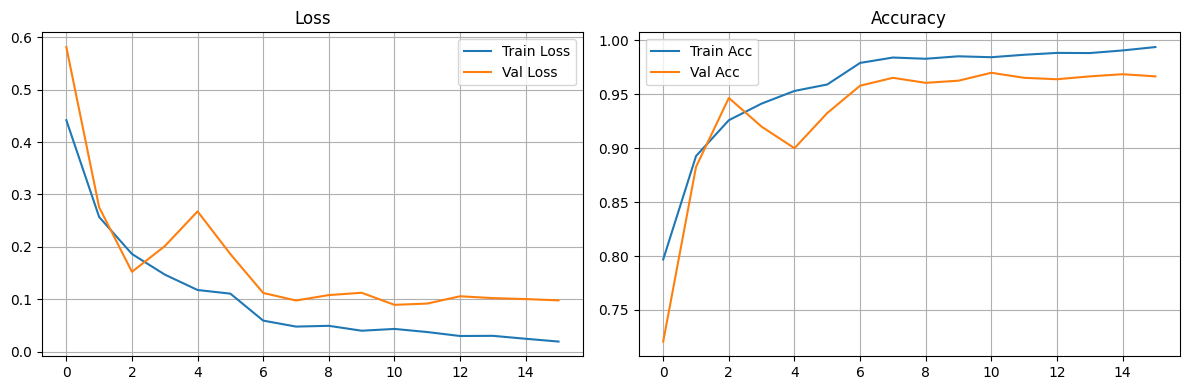

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['t_loss'], label='Train Loss')
plt.plot(history['v_loss'], label='Val Loss')
plt.legend(); plt.title('Loss'); plt.grid()

plt.subplot(1,2,2)
plt.plot(history['t_acc'], label='Train Acc')
plt.plot(history['v_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.grid()
plt.tight_layout()
plt.show()

Testing:   0%|          | 0/47 [00:00<?, ?it/s]


FINAL TEST RESULTS
Accuracy  : 0.9653
Precision : 0.9666
Recall    : 0.9640
F1-Score  : 0.9653


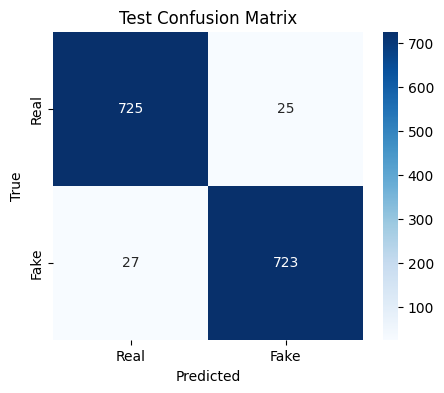

In [ ]:
# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/deepfake_best.pth'))
model.eval()

# Test
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        out = model(x)
        pred = (out > 0.5).float().cpu().numpy().flatten()
        all_preds.extend(pred)
        all_labels.extend(y.numpy())

# Metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()